# Nilgai Camera Trap Classifier
This notebook wlaks through the process of using a trained convolutional neural network (CNN) to make predictions on raw trail camera data. 

In [168]:
# import libraries and dependencies
import tensorflow as tf 
import tensorflow_hub as hub 
import os
import numpy as np 
import pandas as pd
import shutil
import timeit
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

In [60]:
# replace with your own directory location

img_dir = 'F:/Nilgai_photo_database/Nilgai Classifier/Nilgai/sample_images/'
sub_img_dir = 'F:/Nilgai_photo_database/Nilgai Classifier/Nilgai/sample_images/images/'
pred_dir = 'F:/Nilgai_photo_database/Nilgai Classifier/Nilgai/predictions/'
model_path = 'F:/Nilgai_photo_database/Nilgai Classifier/Nilgai/models/Final_binary_nil_05262020.h5'
# dimensions of images
img_width, img_height = 299, 299
class_names = ['Nilgai', 'Not_Nilgai']

path_list = [img_dir, sub_img_dir, pred_dir, model_path]

for p in path_list:
    if os.path.exists(p): pass
    else: print(p + " does not exist. Check your path and/or filenames.")

In [61]:
# load model
model = tf.keras.models.load_model(model_path, custom_objects={'KerasLayer':hub.KerasLayer}, compile=True)

In [189]:
# load all images into a list
timeit.Timer()
images = []
img_f_name = []
img_src_path = []
for img_name in os.listdir(sub_img_dir):
    img = os.path.join(sub_img_dir, img_name)
    img_src_path.append(img)
    img = tf.keras.preprocessing.image.load_img(img, target_size=(img_width, img_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    offset_width = 0
    offset_height = 9
    target_height = 275
    target_width = 299

    img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, target_height, target_width)
    img = tf.image.resize(img, (299,299))

    img = img/255
    img = np.expand_dims(img, axis=0)
    images.append(img)
    img_f_name.append(img_name)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = model.predict_classes(images, batch_size=1)
end = timeit.timeit()
print("Predictions on " + str(len(images)) + " images took " + str(end))


Predictions on 100 images took 0.0063551000002917135


In [152]:
# create new directories based on class names 
for i in class_names:
    cl_dir = os.path.join(pred_dir, str(i))
    try:
        os.makedirs(cl_dir, exist_ok=False)
    except:
        print("The " + '"' + str(i) + '"' + " folder already exists. Check to see if predictions already exist in that folder.")

The "Nilgai" folder already exists. Check to see if predictions already exist in that folder.
The "Not_Nilgai" folder already exists. Check to see if predictions already exist in that folder.


In [173]:
## ## Move images to repsective folders, and print results
timeit.Timer()
counter = 0
for f_name, cl in zip(img_f_name, classes):
    src = os.path.join(sub_img_dir,f_name)
    dir_n = class_names[0] if cl == 0 else class_names[1]
    dst = os.path.join(pred_dir, dir_n)
    shutil.copy(src, dst)
    counter +=1

end = timeit.timeit()
print("Moving " + str(len(classes)) + " images took " + str(end) + " seconds.")

Moving 100 images took 0.006146499999886146 seconds.


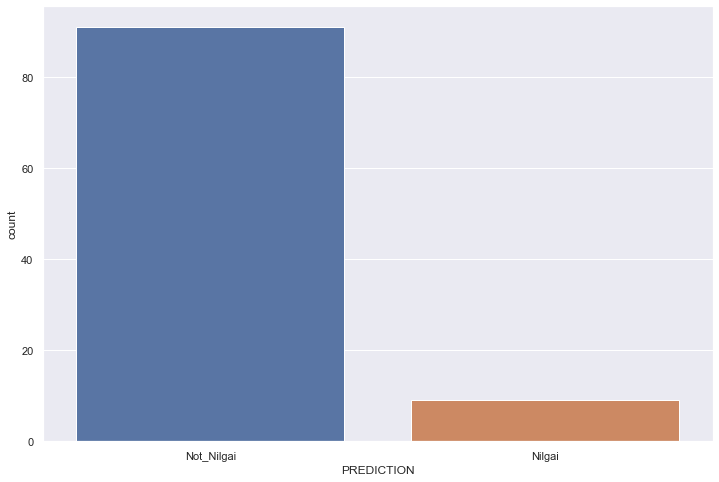

In [190]:
df=pd.DataFrame({'IMGPATH':img_src_path,
                    'PREDICTION_ID':classes.flatten()})
df['PREDICTION'] = df['PREDICTION_ID']
df['PREDICTION'] = np.where(df['PREDICTION_ID']==1, 'Not_Nilgai',df['PREDICTION'])
df['PREDICTION'] = np.where(df['PREDICTION_ID']==0, 'Nilgai',df['PREDICTION'])
df.head()
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.countplot(x="PREDICTION", data=df)

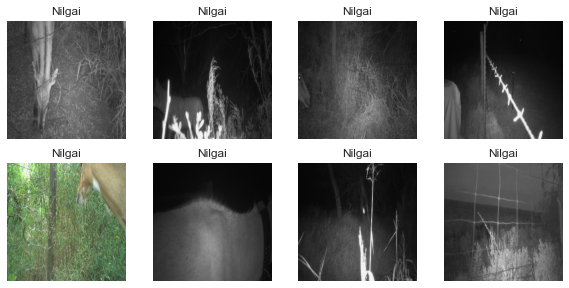

In [277]:
df_plot = df[df['PREDICTION']=='Nilgai']
import cv2 
img_list = []
for row in df_plot.itertuples():
    img = cv2.imread(row.IMGPATH)
    newimage = cv2.resize(img,(299,299))
    crop_img = newimage[10:282, 0:299] # Crop from {x, y, w, h } => {0, 0, 300, 400}
    newimage = cv2.resize(crop_img,(299,299))
    # plt.axis("off")
    # plt.imshow(cv2.cvtColor(newimage, cv2.COLOR_BGR2RGB))
    img_list.append(newimage)


plt.figure(figsize=(10,10))
for n in range(8):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(cv2.cvtColor(img_list[n], cv2.COLOR_BGR2RGB))
      plt.title(df_plot['PREDICTION'].iloc[n])
      plt.axis('off')

plt.show()

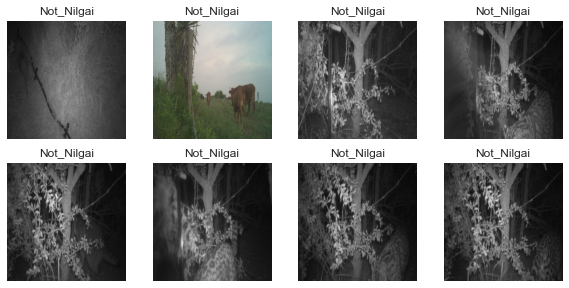

In [279]:
df_plot = df[df['PREDICTION']=='Not_Nilgai']
import cv2 
img_list = []
for row in df_plot.itertuples():
    img = cv2.imread(row.IMGPATH)
    newimage = cv2.resize(img,(299,299))
    crop_img = newimage[10:282, 0:299] # Crop from {x, y, w, h } => {0, 0, 300, 400}
    newimage = cv2.resize(crop_img,(299,299))
    # plt.axis("off")
    # plt.imshow(cv2.cvtColor(newimage, cv2.COLOR_BGR2RGB))
    img_list.append(newimage)


plt.figure(figsize=(10,10))
for n in range(8):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(cv2.cvtColor(img_list[n], cv2.COLOR_BGR2RGB))
      plt.title(df_plot['PREDICTION'].iloc[n])
      plt.axis('off')

plt.show()